# Part 2: Index ETFs - RNN LSTM

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
# import hvplot.pandas
%matplotlib inline

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Loading Data

In [87]:
data_df = pd.read_csv('./Resources/berkshire_final.csv', index_col='Date', parse_dates=True, infer_datetime_format=True)
data_df = data_df.iloc[1:]
data_df


,Market Return,Portfolio Return without Rebalancing,Portfolio Return with Rebalancing,Portfolio Return with Lagged Rebalancing
Date,,,,
2018-07-02,1.002766,1.003619,1.003619,NaN
2018-07-03,0.998673,0.996927,0.996927,NaN
2018-07-05,1.007006,1.005320,1.005320,NaN
2018-07-06,1.015414,1.011935,1.011935,NaN
2018-07-09,1.024706,1.024373,1.024373,NaN
2018-07-10,1.028135,1.026147,1.026147,NaN
2018-07-11,1.021092,1.020610,1.020610,NaN
2018-07-12,1.029905,1.026921,1.026921,NaN
2018-07-13,1.030901,1.026411,1.026411,NaN


## Machine Learning Part

### Create the Features `X` and Target `y` Data

In [88]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [1]:
# Define the window size
window_size = 5

# Set the index of the feature and target columns
feature_column = 2
target_column = 2

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(data_df, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

NameError: name 'window_data' is not defined

#### Split Data Between Training and Testing Sets

To avoid the dataset being randomized, manually create the training and testing sets using array slicing. Use 70% of the data for training and the remainder for testing.

In [90]:
# Manually splitting the data
split = int(0.8*len(X))
X_train = X[:split - 1]
X_test = X[split:]
y_train = y[:split - 1]
y_test = y[split:]

#### Scale Data with `MinMaxScaler`

Before training the RNN LSTM model, use the `MinMaxScaler` from `sklearn` to scale the training and testing data between `0` and `1`.

In [91]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [92]:
print(f'len(X):{len(X)}')
print(f'len(y):{len(y)}')   

len(X):532
len(y):532


#### Reshape Features Data for the LSTM Model

The LSTM API from Keras needs to receive the features data as a _vertical vector_, so that reshape the `X` data in the form `reshape((X_train.shape[0], X_train.shape[1], 1))`. Both sets, training, and testing should be reshaped.

In [93]:
X_train.shape

(424, 5)

In [94]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.43567858]
  [0.42097616]
  [0.4394157 ]
  [0.45394785]
  [0.48127452]]

 [[0.42097616]
  [0.4394157 ]
  [0.45394785]
  [0.48127452]
  [0.48517247]]

 [[0.4394157 ]
  [0.45394785]
  [0.48127452]
  [0.48517247]
  [0.47300694]]] 

X_test sample values:
[[[0.41580044]
  [0.19555443]
  [0.41875762]
  [0.14575868]
  [0.26601683]]

 [[0.19555443]
  [0.41875762]
  [0.14575868]
  [0.26601683]
  [0.15093001]]

 [[0.41875762]
  [0.14575868]
  [0.26601683]
  [0.15093001]
  [0.15974421]]]


In [95]:
X_train.shape


(424, 5, 1)

---

### Build and Train the LSTM RNN

In this section, we will design a custom LSTM RNN in Keras and fit (train) it using the training data we defined.

we will need to:

1. Define the model architecture in Keras.

2. Compile the model.

3. Fit the model with the training data.

In [96]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

#### Create the LSTM RNN Model Structure

Design the structure of the RNN LSTM, we will set it as follows:

* Number of units per layer: `10` (same as the window size)

* Dropout fraction: `0.2` (20% of neurons will be randomly dropped on each epoch)

* Add three `LSTM` layers to the model, remember to add a `Dropout` layer after each `LSTM` layer, and to set `return_sequences=True` in the first two layers only.

* Add a `Dense` output layer with one unit.

In [97]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 5
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

#### Compile the LSTM RNN Model

Compile the model using the `adam` optimizer, and `mean_square_error` as loss function since the value we want to predict is continuous.

In [98]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [99]:
# Show the model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 5, 5)              140       
_________________________________________________________________
dropout_15 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 5, 5)              220       
_________________________________________________________________
dropout_16 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 5)                 220       
_________________________________________________________________
dropout_17 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

#### Train the Model

Train (fit) the model with the training data using `20` epochs and a `batch_size=10`. Since we are working with time-series data, remember to set `shuffle=False` since it's necessary to keep the sequential order of the data.

In [100]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=10, shuffle=False, verbose=1)

Epoch 1/20
43/43 [==============================] - 0s 8ms/step - loss: 0.2567
Epoch 2/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0667
Epoch 3/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0509
Epoch 4/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0467
Epoch 5/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0442
Epoch 6/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0445
Epoch 7/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0410
Epoch 8/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0409
Epoch 9/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0417
Epoch 10/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0305
Epoch 11/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0392
Epoch 12/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0355
Epoch 13/20
43/43 [==============================

#### Evaluate the Model

Use the `evaluate()` method of the model using the testing data.

In [101]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.0062880367040634155

#### Make Predictions

Use the `predict()` method of the model to make some closing gold price predictions using our brand new LSTM RNN model and our testing data. Save the predictions in a variable called `predicted`.

In [102]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [103]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1,1))

#### Plotting Predicted Vs. Real Prices

In [104]:
# Create a DataFrame of Real and Predicted values
test_index = data_df.index[-len(real_prices):]
portfolio_returns = pd.DataFrame({
        "Actual": real_prices.ravel(), "Predicted": predicted_prices.ravel()
}, index=test_index)

# Show the DataFrame's head
portfolio_returns.tail()

,Actual,Predicted
Date,,
2020-08-17,1.202515,1.183704
2020-08-18,1.200419,1.187065
2020-08-19,1.201130,1.188008
2020-08-20,1.197926,1.189155
2020-08-21,1.202183,1.190217


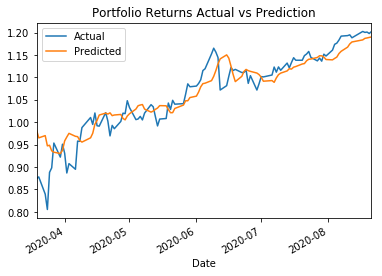

In [105]:
# Plot the real vs predicted prices as a line chart
portfolio_returns.plot(title="Portfolio Returns Actual vs Prediction")

## LSTM Model with two features

In [106]:
def window_data_multi(df, window, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features= df.iloc[i : (i + window), :2].values
#         features_2 = df.iloc[i : (i + window), feature_col_number_2]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)

    return np.array(X), np.array(y).reshape(-1, 1)

In [107]:
# Define the window size
window_size = 5

# Set the index of the feature and target columns

target_column = 2

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data_multi(data_df, window_size,  target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

X sample values:
[[[1.00276559 1.00361942]
  [0.99867252 0.99692738]
  [1.00700616 1.00532044]
  [1.01541355 1.01193498]
  [1.02470593 1.02437317]]

 [[0.99867252 0.99692738]
  [1.00700616 1.00532044]
  [1.01541355 1.01193498]
  [1.02470593 1.02437317]
  [1.02813526 1.02614738]]

 [[1.00700616 1.00532044]
  [1.01541355 1.01193498]
  [1.02470593 1.02437317]
  [1.02813526 1.02614738]
  [1.02109222 1.02061004]]] 

y sample values:
[[1.02614738]
 [1.02061004]
 [1.02692149]]


In [108]:
X.shape

(532, 5, 2)

#### Split Data Between Training and Testing Sets

To avoid the dataset being randomized, manually create the training and testing sets using array slicing. Use 70% of the data for training and the remainder for testing.

In [109]:
# Manually splitting the data
split = int(0.80*len(X))
X_train = X[:split - 1]
X_test = X[split:]
y_train = y[:split - 1]
y_test = y[split:]

In [110]:
print(f'len(X):{len(X)}')
print(f'len(y):{len(y)}')    

len(X):532
len(y):532


#### Scale Data with `MinMaxScaler`

Before training the RNN LSTM model, use the `MinMaxScaler` from `sklearn` to scale the training and testing data between `0` and `1`.

In [111]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit and transform the MinMaxScaler object with the features data X
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [112]:
X_train.shape

(424, 5, 2)

#### Reshape Features Data for the LSTM Model

The LSTM API from Keras needs to receive the features data as a _vertical vector_, so that reshape the `X` data in the form `reshape((X_train.shape[0], X_train.shape[1], 1))`. Both sets, training, and testing should be reshaped.

In [113]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 2))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 2))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.3612127  0.37006509]
  [0.35052935 0.35323255]
  [0.37228104 0.37434366]
  [0.39422522 0.39098126]
  [0.41847931 0.4222671 ]]

 [[0.35052935 0.35323255]
  [0.37228104 0.37434366]
  [0.39422522 0.39098126]
  [0.41847931 0.4222671 ]
  [0.42743022 0.42672978]]

 [[0.37228104 0.37434366]
  [0.39422522 0.39098126]
  [0.41847931 0.4222671 ]
  [0.42743022 0.42672978]
  [0.40904716 0.41280169]]] 

X_test sample values:
[[[0.38450433 0.35658171]
  [0.13176131 0.10507937]
  [0.35149182 0.35378794]
  [0.0481232  0.05348934]
  [0.19037536 0.19485853]]

 [[0.13176131 0.10507937]
  [0.35149182 0.35378794]
  [0.0481232  0.05348934]
  [0.19037536 0.19485853]
  [0.06352262 0.06748837]]

 [[0.35149182 0.35378794]
  [0.0481232  0.05348934]
  [0.19037536 0.19485853]
  [0.06352262 0.06748837]
  [0.06496631 0.0702175 ]]]


---

### Build and Train the LSTM RNN

In this section, we will design a custom LSTM RNN in Keras and fit (train) it using the training data we defined.

we will need to:

1. Define the model architecture in Keras.

2. Compile the model.

3. Fit the model with the training data.

In [114]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

#### Create the LSTM RNN Model Structure

Design the structure of the RNN LSTM, we will set it as follows:

* Number of units per layer: `10` (same as the window size)

* Dropout fraction: `0.2` (20% of neurons will be randomly dropped on each epoch)

* Add three `LSTM` layers to the model, remember to add a `Dropout` layer after each `LSTM` layer, and to set `return_sequences=True` in the first two layers only.

* Add a `Dense` output layer with one unit.

In [115]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 5
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 2))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

#### Compile the LSTM RNN Model

Compile the model using the `adam` optimizer, and `mean_square_error` as loss function since the value we want to predict is continuous.

In [116]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [117]:
# Show the model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 5, 5)              160       
_________________________________________________________________
dropout_18 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 5, 5)              220       
_________________________________________________________________
dropout_19 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 5)                 220       
_________________________________________________________________
dropout_20 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

#### Train the Model

Train (fit) the model with the training data using `20` epochs and a `batch_size=10`. Since we are working with time-series data, remember to set `shuffle=False` since it's necessary to keep the sequential order of the data.

In [118]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=10, shuffle=False, verbose=1)

Epoch 1/20
43/43 [==============================] - 0s 8ms/step - loss: 0.2283
Epoch 2/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0400
Epoch 3/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0406
Epoch 4/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0354
Epoch 5/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0335
Epoch 6/20
43/43 [==============================] - 0s 8ms/step - loss: 0.0312
Epoch 7/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0303
Epoch 8/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0317
Epoch 9/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0251
Epoch 10/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0282
Epoch 11/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0257
Epoch 12/20
43/43 [==============================] - 0s 7ms/step - loss: 0.0211
Epoch 13/20
43/43 [==============================

#### Evaluate the Model

Use the `evaluate()` method of the model using the testing data.

In [119]:
print(X_test.shape)
print(y_test.shape)

(107, 5, 2)
(107, 1)


In [120]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.008036628365516663

#### Make Predictions

Use the `predict()` method of the model to make some closing gold price predictions using our brand new LSTM RNN model and our testing data. Save the predictions in a variable called `predicted`.

In [121]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [122]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1,1))

#### Plotting Predicted Vs. Real Prices

In [123]:
# Create a DataFrame of Real and Predicted values
test_index = data_df.index[-len(real_prices):]
portfolio_returns_2 = pd.DataFrame({
        "Actual": real_prices.ravel(), "Predicted": predicted_prices.ravel()
}, index=test_index)

# Show the DataFrame's head
portfolio_returns_2

,Actual,Predicted
Date,,
2020-03-19,0.874011,0.986486
2020-03-20,0.878023,0.971770
2020-03-23,0.839604,0.971761
2020-03-24,0.805313,0.955698
2020-03-25,0.888134,0.954989
2020-03-26,0.898174,0.945903
2020-03-27,0.953497,0.943788
2020-03-30,0.922141,0.943859
2020-03-31,0.950983,0.952118


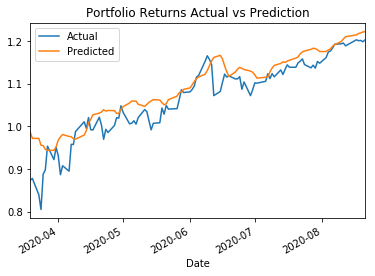

In [124]:
# Plot the real vs predicted prices as a line chart
portfolio_returns_2.plot(title="Portfolio Returns Actual vs Prediction")